In [1]:
import numpy as np
from DSSStartup import DSSStartup
from setInfo import *
from getInfo import *
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd

#######################################################
#######################################################
###Global variable initialization and error checking###
#######################################################
#######################################################
Sbase=1
LoadScalingFactor = 1.5
GenerationScalingFactor = 5 
SlackBusVoltage = 1.04 
NoiseMultiplyer= 0

#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 42900 
EndTime = 44000
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 300
PercentHacked = np.array([0,0,0,0,0,0,0,.5,0,0,.5,.5,.5,.5,.5,0,0,.5,0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VQ_start = 1.01
VQ_end = 1.03
VP_start = 1.03
VP_end = 1.05

#Set delays for each node
                        #1  2  3   4   5  6   7   8      9    10   11   12   13
Delay_VoltageSampling = np.array([0,0,0,0,0,10,10,10,10,10,10,10,10,10,10,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0]) 
Delay_VBPCurveShift =   np.array([0,0,0,0,0,60,60,60,60,60,60,60,60,60,60,60,60,60,0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set observer voltage threshold
ThreshHold_vqvp = 0.25
power_factor=0.9
pf_converted=tan(acos(power_factor))
Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters


#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Appropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')
    
DSSStart = DSSStartup()
DSSText =DSSStart['dsstext']
DSSSolution = DSSStart['dsssolution']
DSSCircuit = DSSStart['dsscircuit']
DSSObj = DSSStart['dssobj']
DSSMon = DSSCircuit.Monitors
DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
DSSSolution.Solve()
if not DSSSolution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    DSSMon.ResetAll
    setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=DSSCircuit.Loads.Count
    AllLoadNames=DSSCircuit.Loads.AllNames
    print('OpenDSS Model Compliation Done.')

#######################################################
#######################################################
####         Load data from file                    ###
#######################################################
#######################################################

#Retrieving the data from the load profile
TimeResolutionOfData=10 #resolution in minute
#Get the data from the Testpvnum folder
#Provide Your Directory - move testpvnum10 from github to drive C: 
FileDirectoryBase ='C:\\feeders\\testpvnum10\\';
QSTS_Time = list(range(1441)) #This can be changed based on the available data - for example, 1440 timesteps
QSTS_Data = np.zeros((len(QSTS_Time) ,4,TotalLoads)) #4 columns as there are four columns of data available in the .mat file

for node in range(TotalLoads):
    #This is created manually according to the naming of the folder
    FileDirectoryExtension = 'node_' + str(node+1) + '_pv_' +str(TimeResolutionOfData) + '_minute.csv'
    #The total file directory
    FileName = FileDirectoryBase + FileDirectoryExtension
    #Load the file
    MatFile = np.genfromtxt(FileName, delimiter=',')    
    QSTS_Data[:,:,node] = MatFile #Putting the loads to appropriate nodes according to the loadlist
    
Generation = QSTS_Data[:,1,:]*GenerationScalingFactor #solar generation
Load = QSTS_Data[:,3,:]*LoadScalingFactor #load demand
Generation = np.squeeze(Generation)/Sbase  #To convert to per unit, it should not be multiplied by 100
Load = np.squeeze(Load)/Sbase
print('Reading Data for Pecan Street is done.')

############################################################
############################################################
#### Interpolate to change data from minutes to seconds ####
############################################################
############################################################

from scipy.interpolate import interp1d

print('Starting Interpolation...')

#interpolation for the whole period...
Time = list(range(StartTime,EndTime))
TotalTimeSteps = len(Time)
LoadSeconds = np.empty([3600*24, TotalLoads])
GenerationSeconds = np.empty([3600*24, TotalLoads])
# Interpolate to get minutes to seconds
for node in range(TotalLoads): # i is node
    t_seconds = np.linspace(1,len(Load[:,node]), int(3600*24/1))
    f = interp1d(range(len(Load[:,node])), Load[:,node], kind='cubic', fill_value="extrapolate")
    LoadSeconds[:,node] = f(t_seconds) #spline method in matlab equal to Cubic Spline -> cubic
    
    f = interp1d(range(len(Generation[:,node])), Generation[:,node], kind='cubic', fill_value="extrapolate")
    GenerationSeconds[:,node]= f(t_seconds)

# Initialization
# then we take out only the window we want...
LoadSeconds = LoadSeconds[StartTime:EndTime,:]
GenerationSeconds = GenerationSeconds[StartTime:EndTime,:]
Load = LoadSeconds
Generation = GenerationSeconds

#Create noise vector
Noise = np.empty([TotalTimeSteps, TotalLoads])
for node in range(TotalLoads):
    Noise[:,node] = np.random.randn(TotalTimeSteps) 

#Add noise to loads
for node in range(TotalLoads):
    Load[:,node] = Load[:,node] + NoiseMultiplyer*Noise[:,node]

if NoiseMultiplyer > 0:
    print('Load Interpolation has been done. Noise was added to the load profile.') 
else:
    print('Load Interpolation has been done. No Noise was added to the load profile.') 
    
MaxGenerationPossible = np.max(Generation, axis = 0)
sbar = MaxGenerationPossible


############################################################
############################################################
#### Function for simulation################################
############################################################
############################################################

def inverter_qp_injection(counter, Vk, Vkm1, gammakm1,solar_irr,VBP,Sbar, dv, T=1, lpf=1):
    pk = 0
    qk = 0
    c = 0
    q_avail = 0

    solar_range = 5

    Vmagk = abs(Vk)
    Vmagkm1 = abs(Vkm1)
    gammakcalc = (T*lpf*(Vmagk + Vmagkm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)

    if counter % dv == 0:
        gammakused = gammakcalc
    else :
        gammakused = gammakm1

    if solar_irr < solar_range:
        pk = 0
        qk = 0
    elif solar_irr >= solar_range:
        if gammakused <= VBP[2]:
            pk = -solar_irr
            q_avail = (Sbar**2 - pk**2)**(1/2)
            if gammakused <= VBP[0]:
                qk = 0
            elif gammakused > VBP[0] and gammakused <= VBP[1]:
                c = q_avail/(VBP[1] - VBP[0])
                qk = c*(gammakused - VBP[0])
            else:
                qk = q_avail
        elif gammakused > VBP[2] and gammakused < VBP[3]:
            d = -solar_irr/(VBP[3] - VBP[2])
            pk = -(d*(gammakused - VBP[2]) + solar_irr)
            qk = (Sbar**2 - pk**2)**(1/2)
        elif gammakused >= VBP[3]:
            qk = Sbar
            pk = 0
    return qk,pk, gammakused
    
def voltage_observer(vk, vkm1, psikm1, epsilonkm1, ykm1, f_hp=1, f_lp=0.1, gain=1e5, T=1):
    Vmagk = abs(vk)
    Vmagkm1 = abs(vkm1)
    psik = (Vmagk - Vmagkm1 - (f_hp*T/2-1)*psikm1)/(1+f_hp*T/2)
    epsilonk = gain*(psik**2)
    yk = (T*f_lp*(epsilonk + epsilonkm1) - (T*f_lp - 2)*ykm1)/(2 + T*f_lp)
    return yk, psik, epsilonk

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
Reading Data for Pecan Street is done.
Starting Interpolation...
Load Interpolation has been done. No Noise was added to the load profile.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 60, 3)        0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 60, 15)       1140        input_7[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 15)           1860        lstm_7[0][0]                     
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 2)            32          lstm_8[0][0]                     
__________________________________________________________________________________________________
lambda_7 (

D:\Apps\Anacoda3\lib\site-packages\ipykernel_launcher.py:371: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


1211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693703713723733743753763773783793803813823833843853863873883893903913923933943953963973983994004014024034044054064074084094104114124134144154164174184194204214224234244254264274284294304314324334344354364374384394404414424434444454464474484494504514524534

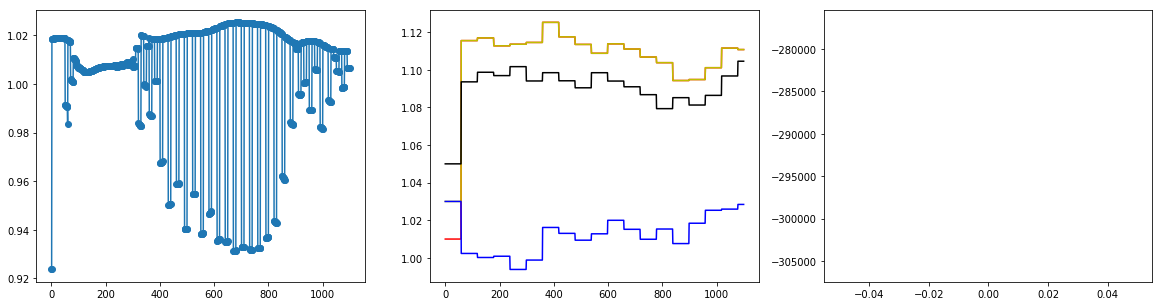

episode: 1
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299300301302303304305306307308309310311312313314315316317318319320321322323324325326327328329330331332333334335336337338

In [ ]:
############################################################
############################################################
#### implementation DDPG with KERAS ########################
############################################################
############################################################

import numpy as np
import math
from keras.initializers import normal, identity, uniform
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, Lambda, Activation, LSTM, Concatenate, Add, multiply, Reshape
from keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K

############ ACTOR ############
###############################
class ActorNetwork(object):
    def __init__(self, sess, state_dim, action_dim, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE

        #we run this on the same session
        K.set_session(sess)

        #We create actor and target actor
        self.model , self.weights, self.state = self.create_actor_network(state_dim, action_dim, action_bound = 0.25)   
        self.target_model, self.target_weights, self.target_state = self.create_actor_network(state_dim, action_dim) 
        
        self.action_gradient = tf.placeholder(tf.float32,[None, 1, action_dim])
        self.params_u_grad = tf.gradients(self.model.output, self.weights, -self.action_gradient)
        self.params_grad = list(map(lambda x: tf.div(x, self.BATCH_SIZE), self.params_u_grad)) 

        grads = zip(self.params_grad, self.weights)
        
        self.optimize = tf.train.AdamOptimizer(LEARNING_RATE).apply_gradients(grads) 
        self.sess.run(tf.global_variables_initializer())

    def train(self, states, action_grads):
        self.sess.run(self.optimize, feed_dict={
            self.state: states,
            self.action_gradient: action_grads
        })

    # we update target actor after a batch
    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.TAU * actor_weights[i] + (1 - self.TAU)* actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)

    #define NN architecture
    def create_actor_network(self, state_dim, action_dim, action_bound = 1, shift = 0.9):
        model = Sequential()
        S = Input(shape=state_dim)   
        h0 = LSTM(15, return_sequences=True)(S)
        h2 = LSTM(15)(h0)
        h3 = Dense(action_dim//2, activation='sigmoid')(h2)
        h4 = Dense(action_dim//2, activation='sigmoid')(h2)

        V3 = Lambda(lambda x: x * action_bound + shift)(h3) #this layer is for the a1 a3

        V3x = Lambda(lambda x: action_bound + shift - x)(V3) # this layer is the new action_bound for a2 a4
        V4 = Lambda(lambda x: multiply([x[0],x[1]]) + x[2])([h4, V3x, V3]) #get new value 
        
        V3 = Reshape((1, 2))(V3)
        V4 = Reshape((1, 2))(V4)
        V = Concatenate()([V3,  V4])
        model = Model(inputs=S,outputs=V)
        return model, model.trainable_weights, S

############ CRITIC ###########
###############################
class CriticNetwork(object):
    def __init__(self, sess, state_dim, action_dim, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE
        self.action_dim = action_dim
        
        K.set_session(sess)

        #Now create the model
        self.model, self.action, self.state = self.create_critic_network(state_dim, action_dim)  
        self.target_model, self.target_action, self.target_state = self.create_critic_network(state_dim, action_dim)  
        
        self.action_grads = tf.gradients(self.model.output, self.action)  #GRADIENTS for policy update
        self.sess.run(tf.global_variables_initializer())

    #
    def gradients(self, states, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.state: states,
            self.action: actions
        })[0]

    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.TAU * critic_weights[i] + (1 - self.TAU)* critic_target_weights[i]
        
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self, state_dim, action_dim):
        S = Input(shape=state_dim)  
        A = Input(shape=(1,action_dim))   
           
        h0 = LSTM(20)(S)
        V = Dense(10, kernel_initializer='he_uniform', activation='relu')(h0)
        VA = Dense(10, kernel_initializer='he_uniform', activation='relu')(A)
        
        h = Add()([V,VA])    
        h3 = Dense(5, kernel_initializer='he_uniform', activation='relu')(h)
        V = Dense(1,activation='linear')(h3)
        model = Model(inputs=[S,A],outputs=V)
        adam = Adam(lr=self.LEARNING_RATE)
        
        model.compile(loss='mse', optimizer=adam)
        return model, A, S 

#####################################################
#################### INIT AGENT #####################
#####################################################
import tensorflow as tf
#Tensorflow GPU optimization
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
import sys
sys.path.append('C:\\Users\\Toan Ngo\\Documents\\GitHub\\ceds-cigar\\LBNL_Simulations\\Python\\InverterStability')
from replay_buffer import ReplayBuffer
from random_process import OrnsteinUhlenbeckProcess

BUFFER_SIZE = 300 #around 18 eps
BATCH_SIZE = 60 
GAMMA = 0.99
TAU = 0.001 
LRA = 0.0001    
LRC = 0.001     
EXPLORE = 1000 #explore in 75 eps
action_dim = 4  
state_dim = (60,3)

actor = ActorNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRA)
print(actor.model.summary())
critic = CriticNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRC)
print(critic.model.summary())
buff = ReplayBuffer(BUFFER_SIZE)
randomNoise = OrnsteinUhlenbeckProcess(size=action_dim, n_steps_annealing=EXPLORE, sigma_min = 0, theta = 0.05, sigma=0.05)

totalPoints = []
for ep in range(300):    
    print("episode:", ep)
    #########################################################
    ################### RESTART OPENDSS #####################
    #########################################################
    DSSStart = DSSStartup()
    DSSText =DSSStart['dsstext']
    DSSSolution = DSSStart['dsssolution']
    DSSCircuit = DSSStart['dsscircuit']
    DSSObj = DSSStart['dssobj']
    DSSMon = DSSCircuit.Monitors
    DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
    DSSSolution.Solve()
    if not DSSSolution.Converged:
        print('Initial Solution Not Converged. Check Model for Convergence')
    else:
        print('Initial Model Converged. Proceeding to Next Step.')
        #Doing this solve command is required for GridPV, that is why the monitors
        #go under a reset process
        DSSMon.ResetAll
        setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
        #Easy process to get all names and count of loads, a trick to avoid
        #some more lines of code
        TotalLoads=DSSCircuit.Loads.Count
        AllLoadNames=DSSCircuit.Loads.AllNames
        print('OpenDSS Model Compliation Done.')

    ############################################
    ############ INIT NODES ####################
    ############################################
    nodes = {}
    features = ['Voltage', 'Generation', 'P', 'Q']

    for i in range(len(AllLoadNames)):
        df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
        nodes[i] = df
        nodes[i].loc['Generation'] = Generation[:,i]
        nodes[i].loc['P'] = 0
        nodes[i].loc['Q'] = 0

    ################################################
    ############ INIT INVERTERS ####################
    ################################################
    inverters = {}
    features = ['VBP', 'FilterVoltage', 'Generation', 'sbar', 'P_inv', 'Q_inv' ,'counter', 'ime_output', 'ep_output', 'yk']

    offset = 5
    numberofInverters = Number_of_Inverters

    for i in range(len(AllLoadNames)):
        inverters[i] = []
        if offset-1 < i < numberofInverters + offset:
            df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
            df.at['FilterVoltage', 0] = 0
            df.loc['Generation'] = Generation[:,i]
            df.loc['sbar'] = sbar[i]
            df.loc['counter'] = 0
            df.loc['ime_output'] = 0
            df.loc['ep_output'] = 0
            df.loc['yk'] = 0
            df.loc['P_inv'] = 0
            df.loc['Q_inv'] = 0
            inverters[i].append(df)

    ############################################
    ########### INIT VBPCURVE ##################
    ############################################
    for i in range(len(AllLoadNames)):
        for j in range(len(inverters[i])):
            for k in range(TotalTimeSteps):
                inverters[i][j].at['VBP',k] = np.array([1.01, 1.03, 1.03, 1.05])

    VBPcounter = 0
    terminal = False
    executeAction = False

    controlInv = 7
    
    #init action
    oldAction = []
    action = None

    #init state
    oldState = []
    state = []

    #init reward
    reward = None
    addBuffer = True
    
    points = 0
    
    for timeStep in range(TotalTimeSteps):
        print(timeStep, end="")
        VBPcounter += 1 
        ####################################################
        ################ run the simulation ################
        ####################################################
        #for the first steps, we just init voltage value, no pq injection
        if timeStep == 0:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node]])
        else:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                #adding P Q
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node] + nodes[node].at['P', timeStep-1]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node] + nodes[node].at['Q', timeStep-1]])

        DSSSolution.Solve()
        if (not DSSSolution.Converged):
            print('Solution Not Converged at Step:', timeStep)

        #get the voltage info
        nodeInfo = getLoadInfo(DSSObj, [])
        #distribute voltage to node
        for i in range(len(nodes)):
            node = nodes[i]
            node.at['Voltage', timeStep] = nodeInfo[i]['voltagePU']
        #############################################################
        #############################################################
        if timeStep == TimeStepOfHack:
            for node in range(len(AllLoadNames)):
                if inverters[node] != []:
                    inverter = inverters[node][0]
                    #create new inverter
                    hackedInv = copy.deepcopy(inverter)
                    for k in range(timeStep, TotalTimeSteps):
                        hackedInv.at['VBP',k] = np.array([1.01, 1.015, 1.015, 1.02])

                    hackedInv.loc['sbar'][timeStep:] = hackedInv.loc['sbar'][timeStep:]*PercentHacked[node]
                    hackedInv.loc['Generation'][timeStep:] = hackedInv.loc['Generation'][timeStep:]*PercentHacked[node]
                    inverters[node].append(hackedInv)
                    #generation and sbar change on the original inverter
                    inverter.loc['sbar'][timeStep:] = inverter.loc['sbar'][timeStep:]* (1-PercentHacked[node])
                    inverter.loc['Generation'][timeStep:] = inverter.loc['Generation'][timeStep:]*(1-PercentHacked[node])


        if timeStep == TotalTimeSteps-1:
            terminal = True
            
        if timeStep != 0:
            for node in range(len(AllLoadNames)):
                #if we have inverters at that node then...
                if inverters[node] != []:
                    invertersNode = inverters[node] #get the list of inverters at that node
                    for inverter in invertersNode: #get an inverter at that node
                        #increase the counter
                        inverter.at['counter',timeStep] = inverter.at['counter',timeStep-1] + 1
                        if inverter.at['counter',timeStep-1] == Delay_VoltageSampling[node]:
                            inverter.at['counter',timeStep] = 1

                        #get State
                        if inverters[controlInv][0] is inverter:
                            length = Delay_VBPCurveShift[controlInv]
                            if VBPcounter == Delay_VBPCurveShift[controlInv] or terminal == True:
                                if terminal == False:
                                    length = Delay_VBPCurveShift[controlInv]
                                    V = nodes[controlInv].loc['Voltage',timeStep-length+1:timeStep]
                                    G = inverter.loc['Generation', timeStep-length+1:timeStep] 
                                    L = Load[timeStep-length+1:timeStep+1, node]
                                else:
                                    addBuffer = False
                                    length = VBPcounter
                                    V = nodes[controlInv].loc['Voltage',timeStep-length+1:]
                                    G = inverter.loc['Generation', timeStep-length+1:]
                                    L = Load[timeStep-length+1:, node]
                                    #print(V.shape, G.shape, L.shape)
                                    
                                oldState = state
                                #state = np.array([V - np.mean(V),G - np.mean(G)]).T
                                state = np.array([V, G, L]).T
                                #reset VBPcounter
                                VBPcounter = 0
                                #execute action                        
                                oldAction = copy.deepcopy(action)
                                #get action from Agent
                                #get sample action
                                #point13 = np.random.rand(2,)
                                #point24 = point13 + np.random.rand(2,)
                                if addBuffer == True:
                                    action = actor.model.predict(state.reshape([1, 60, 3]))[0][0]
                                    action += randomNoise.sample()
                                    if action[0] > action[2]:
                                        action[0] = action[2]
                                    if action[1] > action[3]:
                                        action[1] = action[3]
                                        
                                    action = np.clip(action, 0.9, 1.15)
                                    applyAction = copy.deepcopy(action)
                                    applyAction[1] = action[2]
                                    applyAction[2] = action[1]

                                    #set VBP
                                    for k in range(timeStep, TotalTimeSteps):
                                        inverter.at['VBP',k] = copy.deepcopy(applyAction)
                                
                                #reward
                                #caculate yk for that inverter
                                inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                                numberYks = inverter.loc['yk', timeStep-length+1:timeStep]
                                reward = - sum(numberYks**2)
                                
                                #sum of reward for that ep
                                points += reward
                                
                                if oldAction != [] and oldState != [] and addBuffer == True:
                                    #push exp to buffer
                                    buff.add(oldState, oldAction, reward, terminal, state)
                        
                        y_b = np.empty(BATCH_SIZE) 
                        #################################################
                        if buff.size() > BATCH_SIZE:
                            s_b, a_b, r_b, t_b, s2_b = buff.sample_batch(BATCH_SIZE)
                            target_ac = actor.target_model.predict(s2_b)
                            target_q = critic.target_model.predict([s2_b, target_ac.reshape([BATCH_SIZE, 1, 4])])
                            
                            
                            for k in range(BATCH_SIZE):
                                if t_b[k]:
                                    y_b[k] = rewards[k]
                                else:
                                    y_b[k] = r_b[k] + GAMMA * target_q[k,0,0]
                                    
                            y_b = y_b.reshape(BATCH_SIZE, 1, 1)
                            
                            #update critic by minimizing the loss L
                            critic.model.train_on_batch([s_b,a_b.reshape([BATCH_SIZE, 1, 4])], y_b)
                            
                            #get action for each state in the batch from the actor
                            a_for_grad = actor.model.predict(s_b)
                            grads = critic.gradients(s_b, a_for_grad.reshape([BATCH_SIZE, 1, 4]))                            
                            actor.train(s_b, grads)
                            
                            #update target actor & critic
                            actor.target_train()
                            critic.target_train()
                        #################################################	
                        #execute action
                        inverter.at['Q_inv', timeStep], inverter.at['P_inv', timeStep], inverter.at['FilterVoltage', timeStep] = inverter_qp_injection(
                            inverter.at['counter',timeStep],
                            nodes[node].at['Voltage', timeStep],
                            nodes[node].at['Voltage', timeStep-1],
                            inverter.at['FilterVoltage', timeStep-1],
                            inverter.at['Generation', timeStep],
                            inverter.at['VBP', timeStep],
                            inverter.at['sbar', timeStep],
                            Delay_VoltageSampling[node])

                        inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                        #caculate P Q injection at the node
                        nodes[node].at['P', timeStep] += inverter.at['P_inv', timeStep]
                        nodes[node].at['Q', timeStep] += inverter.at['Q_inv', timeStep]
                        
    totalPoints.append(points)
    x = inverters[7][0].loc['VBP']
    v = nodes[7].loc['Voltage']
    y=np.zeros([len(x),x[0].shape[0]])
    for i in range(len(x)):
        y[i,:] = x[i]

    
    f = plt.figure()
    f.set_figheight(5)
    f.set_figwidth(20)
    f.add_subplot(1,3,1)
    plt.plot(nodes[7].loc['Voltage'], marker='o')
    f.add_subplot(1,3,2)
    plt.plot(y[:,0], 'r')
    plt.plot(y[:,1], 'y')
    plt.plot(y[:,2], 'b')
    plt.plot(y[:,3], 'k')
    
    f.add_subplot(1,3,3)
    plt.plot(totalPoints)
    plt.show(block=True)
    f.savefig(str(ep) + '.png')
